In [7]:
import pandas as pd
import numpy as np
from collections import Counter
import pickle
from tqdm import tqdm
from pubchempy import Compound
from rdkit import Chem, DataStructs
from rdkit.Chem import SaltRemover, QED
from molvs import Standardizer
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Datasets Task 1: Prepare Matriptase Dataset

Author: Kaan Donbekci (donbekci@stanford.edu)

## Contents
* [1.1 Assemble Dataset](#1.1-Assemble-Dataset)
* [1.2 Sanitize Molecules](#1.2-Sanitize-Molecules)
* [1.3 Remove non-druglike molecules](#1.3-Remove-non-druglike-molecules)
* [1.4 Resolve errors](#1.4-Resolve-errors)
    * [1.4.1 Calculate pairwise similarities using fingerprints](#1.4.1-Calculate-pairwise-similarities-using-fingerprints)
    * [1.4.2 Find and remove duplicates](#1.4.2-Find-and-remove-duplicates) # TODO
    * [1.4.3 Find and remove activity cliffs](#1.4.3-Find-and-remove-activity-cliffs) # TODO
* [Exports](#Exports)

## 1.1 Assemble Dataset

In [18]:
df = pd.read_csv('../data/ST14.csv')

In [19]:
def tie_breaker(values):
    pass   

In [110]:
np.nanmedian([np.nan])

/home/kaandonbekci/anaconda3/envs/covid/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


nan

In [14]:
df = df[pd.notna(df.acvalue)]

In [6]:
# EXPORT
cid_to_smiles = {}
cid_to_activity = {}
cid_to_compound = {}

In [7]:
for i, row in tqdm(df.iterrows(), total=len(df)):
    cid = row.cid
    if cid in cid_to_compound:
        cid_to_activity[cid].append(row.acvalue)
    else:
        compound = Compound.from_cid(cid)
        cid_to_smiles[cid] = compound.isomeric_smiles
        cid_to_activity[cid] = [row.acvalue]
        cid_to_compound[cid] = compound
cid_to_activity = {cid: np.median(cid_to_activity[cid]) for cid in cid_to_activity}

100%|██████████| 365/365 [03:43<00:00,  1.63it/s]


## 1.2 Sanitize Molecules

In [9]:
# EXPORT
cid_to_molecule = {}
cid_to_standardized_molecule = {}
cid_to_salt_removed_molecule = {}

In [10]:
s = Standardizer()
remover = SaltRemover.SaltRemover()
print(f'len(remover.salts) = {len(remover.salts)}')

len(remover.salts) = 15


In [11]:
for cid, smiles in tqdm(cid_to_smiles.items()):
    mol = Chem.MolFromSmiles(smiles)
    standardized_mol = s.standardize(mol)
    salt_removed = remover.StripMol(mol)
    cid_to_molecule[cid] = mol
    cid_to_standardized_molecule[cid] = standardized_mol
    cid_to_salt_removed_molecule[cid] = salt_removed

100%|██████████| 325/325 [00:00<00:00, 428.56it/s]


## 1.3 Remove non-druglike molecules

In [12]:
property_keys = {'molecular weight': 'MW', 'polar surface area': 'PSA', 'LogP': 'ALOGP', 
                 'rotateable bonds': 'ROTB', 'h-bond donors': 'HBD', 'h-bond acceptors': 'HBA'}

In [13]:
# EXPORT
qed_properties = {key: {} for key in property_keys}

In [14]:
for cid, mol in tqdm(cid_to_salt_removed_molecule.items()):
    mol_props = QED.properties(mol)
    for key in property_keys:
        qed_properties[key][cid] = mol_props.__getattribute__(property_keys[key])
qed_properties_df = pd.DataFrame(qed_properties)

100%|██████████| 325/325 [00:00<00:00, 677.97it/s]


In [15]:
qed_properties_df.index.name = 'cid'
qed_properties_df.head()

,molecular weight,polar surface area,LogP,rotateable bonds,h-bond donors,h-bond acceptors
cid,,,,,,
44436348,1513.811,549.21,-5.30250,18,17,23
11974,470.165,118.20,3.62764,8,4,4
432298,346.390,118.20,3.83934,6,4,4
411406,480.350,118.20,3.87754,11,4,4
135435498,502.538,189.64,6.80314,6,6,4


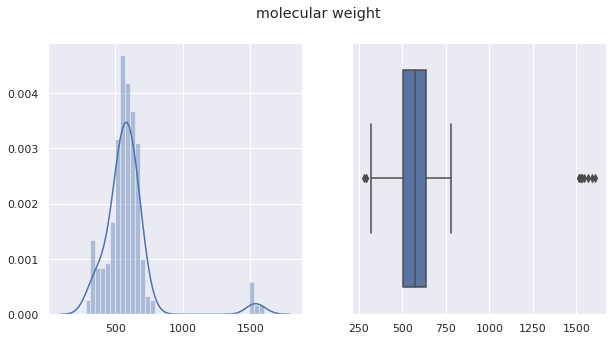

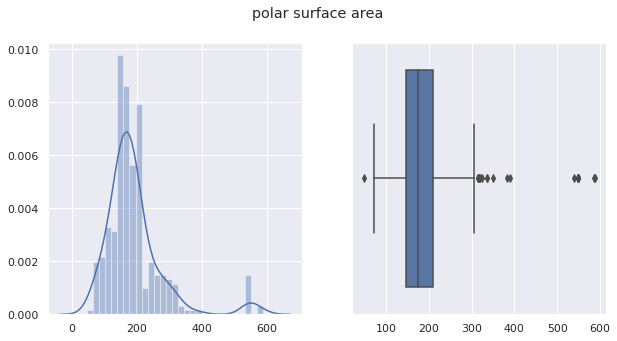

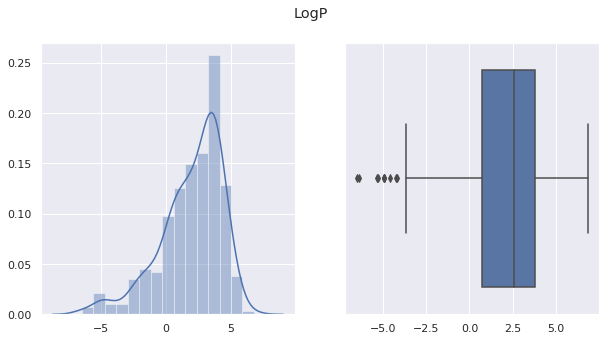

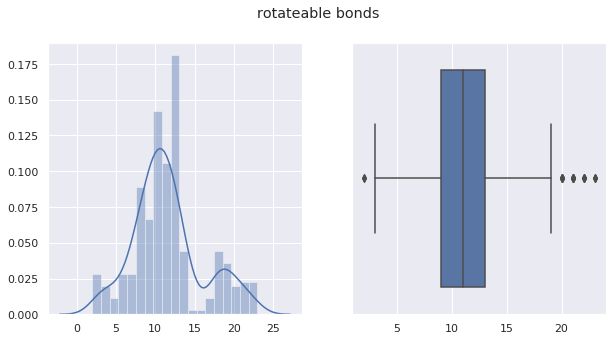

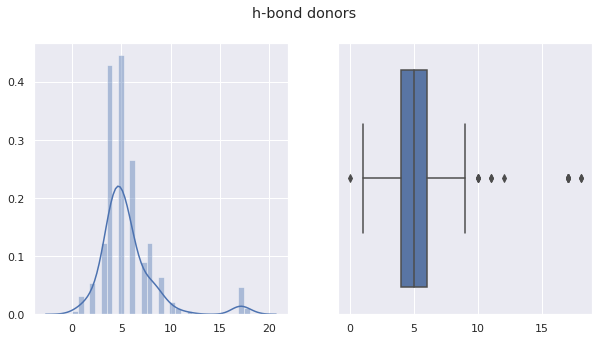

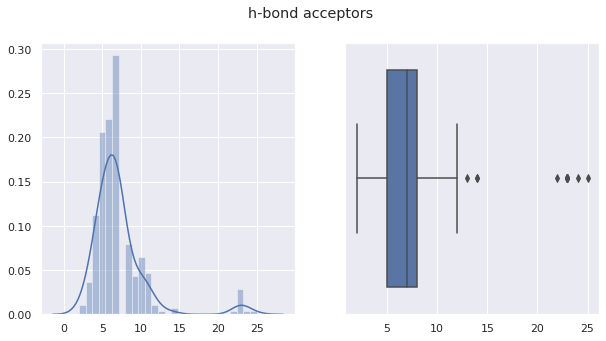

In [16]:
for key, prop in qed_properties.items():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    fig.suptitle(key)
    sns.boxplot(list(prop.values()), ax=axes[1])
    sns.distplot(list(prop.values()), ax=axes[0])

In [17]:
Q1 = qed_properties_df.quantile(.25)
Q3 = qed_properties_df.quantile(.75)
IQR = Q3 - Q1
threshold = 1.5

In [18]:
qed_properties_outliers_removed_df = qed_properties_df[~(((qed_properties_df < (Q1 - threshold*IQR)) |  (qed_properties_df > (Q3 + threshold*IQR))).any(axis=1))]
print(f'{len(qed_properties_df) - len(qed_properties_outliers_removed_df)} outliers removed.')

43 outliers removed.


In [19]:
qed_properties_outliers_removed = qed_properties_outliers_removed_df.to_dict()
cids_to_keep = list(qed_properties_outliers_removed_df.index)

In [20]:
# EXPORT
cid_to_molecule_outliers_removed = {cid: cid_to_salt_removed_molecule[cid] for cid in cids_to_keep}
cid_to_activity_outliers_removed = {cid: cid_to_activity[cid] for cid in cids_to_keep}
cid_to_smiles_outliers_removed = {cid: Chem.MolToSmiles(mol) for cid, mol in cid_to_molecule_outliers_removed.items()}

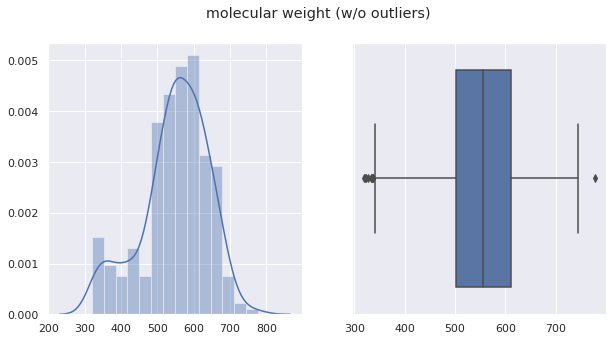

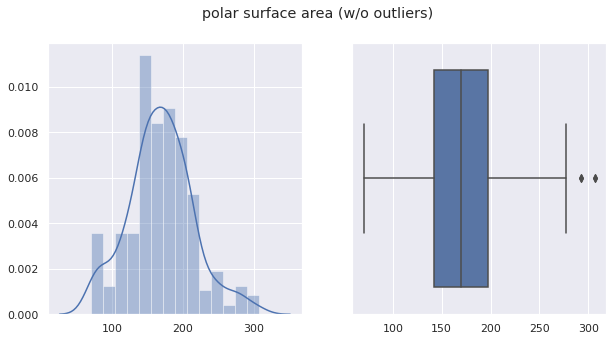

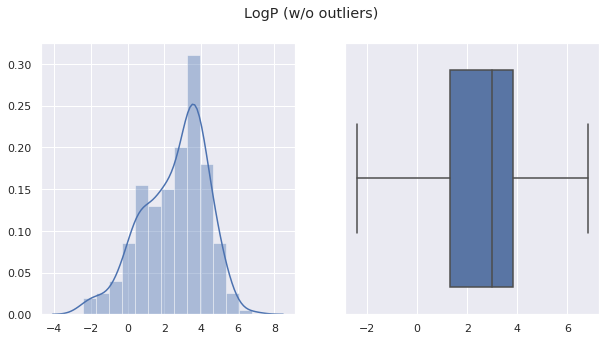

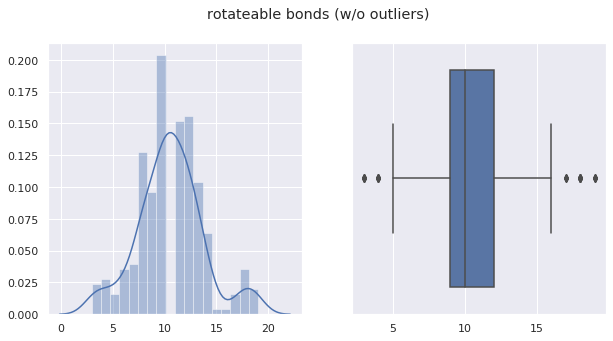

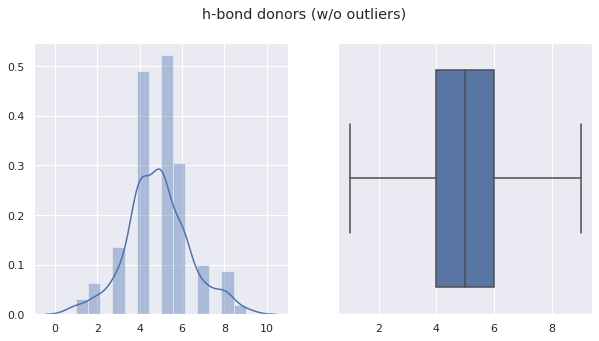

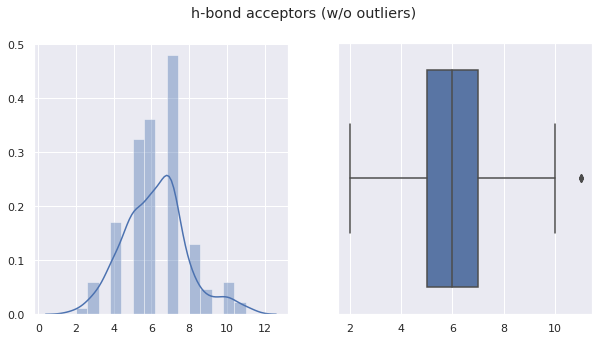

In [21]:
for key, prop in qed_properties_outliers_removed.items():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    fig.suptitle(f'{key} (w/o outliers)')
    sns.boxplot(list(prop.values()), ax=axes[1])
    sns.distplot(list(prop.values()), ax=axes[0])

## 1.4 Resolve errors

### 1.4.1 Calculate pairwise similarities using fingerprints

In [22]:
N = len(cids_to_keep)

In [23]:
# EXPORT
cid_to_fingerprint_outliers_removed = {cid: Chem.RDKFingerprint(mol) for cid, mol in cid_to_molecule_outliers_removed.items()}
fingerprint_similarity_matrix = np.empty((N, N))

In [24]:
for i, (cid1, fps1) in tqdm(enumerate(cid_to_fingerprint_outliers_removed.items()), total=len(cid_to_fingerprint_outliers_removed)):
    for j, (cid2, fps2) in enumerate(cid_to_fingerprint_outliers_removed.items()):
        fingerprint_similarity_matrix[i, j] = DataStructs.FingerprintSimilarity(fps1, fps2)

100%|██████████| 282/282 [00:00<00:00, 1137.08it/s]


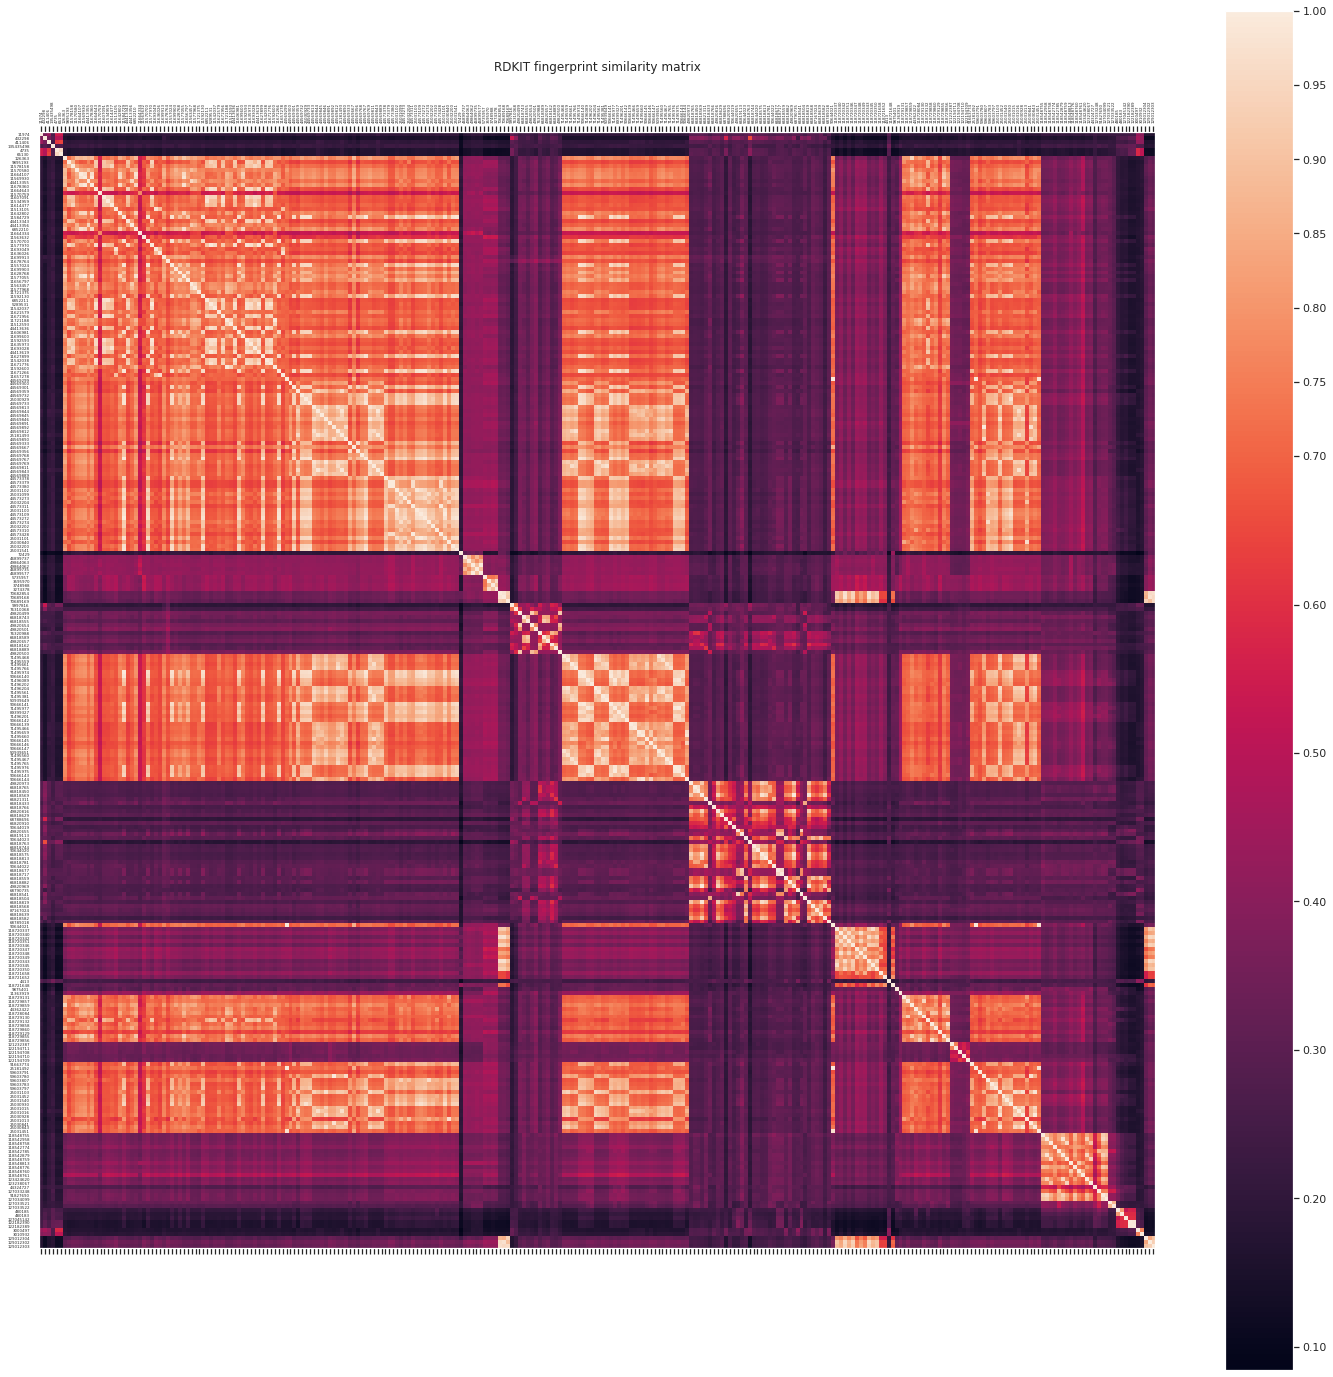

In [25]:
fig, ax = plt.subplots(figsize=(25,25))
cax = ax.matshow(fingerprint_similarity_matrix, interpolation='nearest')
ax.grid(False)
plt.title('RDKIT fingerprint similarity matrix')
plt.xticks(range(N), cids_to_keep, rotation=90);
plt.yticks(range(N), cids_to_keep);
ax.tick_params(axis='both', which='major', labelsize=4)
_=fig.colorbar(cax, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, .75,.8,.85,.90,.95,1])
plt.savefig('dumps/fingerprint_similarity_matrix.png', dpi=400)

/home/kaandonbekci/anaconda3/envs/covid/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


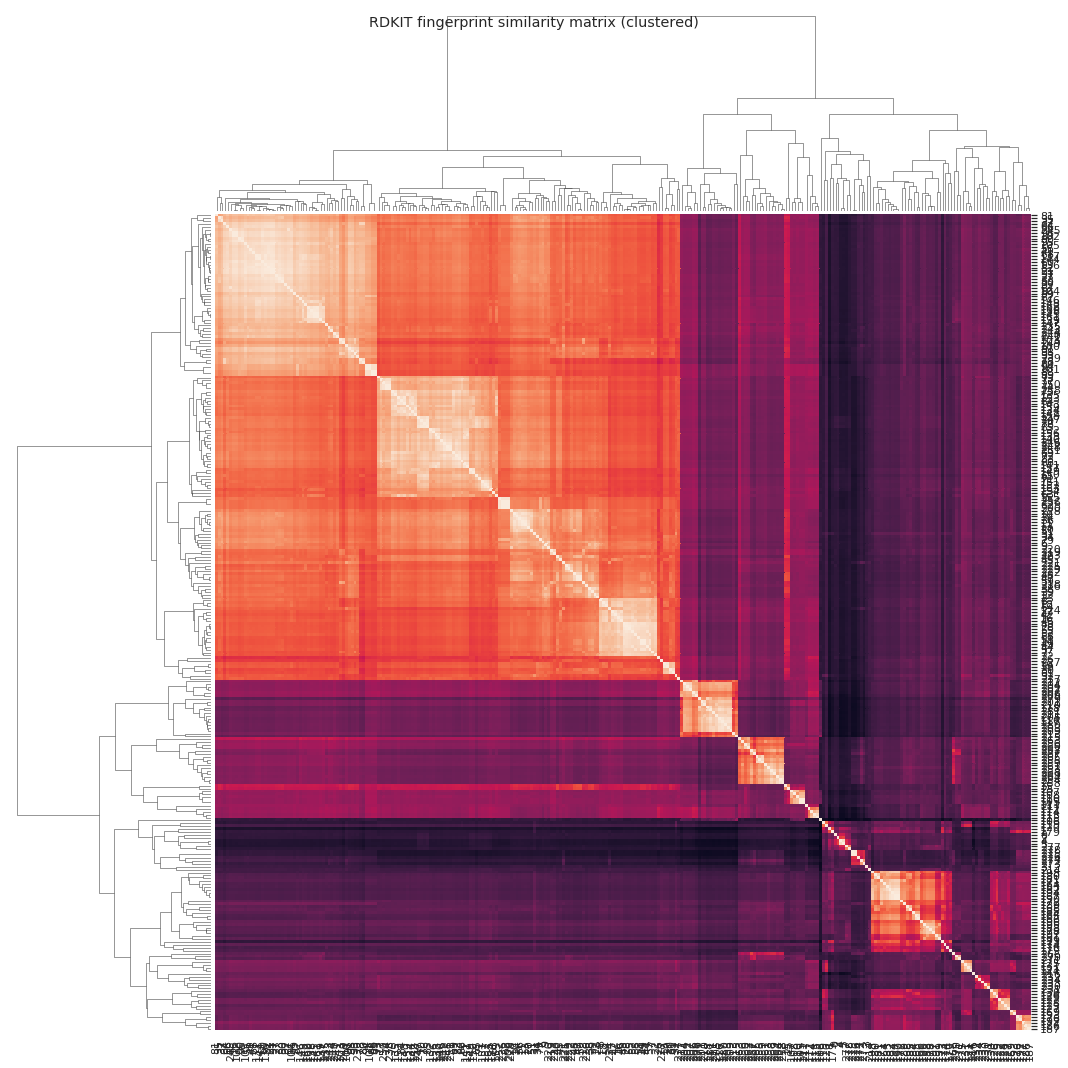

In [26]:
cg = sns.clustermap(fingerprint_similarity_matrix, xticklabels=True, yticklabels=True, cbar_pos=None, figsize=(15, 15))
plt.xticks(rotation=90)
fig = cg.fig
_ = fig.suptitle('RDKIT fingerprint similarity matrix (clustered)')
plt.savefig('dumps/fingerprint_similarity_matrix_clustered', dpi=400)

### 1.4.2 Find and remove duplicates

In [26]:
upper_triangle = (~np.eye(fingerprint_similarity_matrix.shape[0],dtype=bool) * np.triu(fingerprint_similarity_matrix))

### 1.4.3 Find and remove activity cliffs

## Exports

In [11]:
def save_pickle(obj, filename):
    with open(f'../dumps/{filename}.pkl', 'wb') as f:
        pickle.dump(obj, f)

In [12]:
def load_pickle(filename):
    with open(f'../dumps/{filename}.pkl', 'rb') as f:
        return pickle.load(f)

In [29]:
%%time
save_pickle(cid_to_activity, 'cid_to_activity')
save_pickle(cid_to_compound, 'cid_to_compound')
save_pickle(cid_to_smiles, 'cid_to_smiles')
save_pickle(cid_to_molecule, 'cid_to_molecule')
save_pickle(cid_to_standardized_molecule, 'cid_to_standardized_molecule')
save_pickle(cid_to_salt_removed_molecule, 'cid_to_salt_removed_molecule')
save_pickle(qed_properties, 'qed_properties')
save_pickle(qed_properties_outliers_removed, 'qed_properties_outliers_removed')
save_pickle(cid_to_molecule_outliers_removed, 'cid_to_molecule_outliers_removed')
save_pickle(cid_to_activity_outliers_removed, 'cid_to_activity_outliers_removed')
save_pickle(cid_to_smiles_outliers_removed, 'cid_to_smiles_outliers_removed')
save_pickle(cid_to_fingerprint_outliers_removed, 'cid_to_fingerprint_outliers_removed')

CPU times: user 229 ms, sys: 11.9 ms, total: 240 ms
Wall time: 277 ms


In [13]:
%%time
cid_to_activity = load_pickle('cid_to_activity')
cid_to_compound = load_pickle('cid_to_compound')
cid_to_smiles = load_pickle('cid_to_smiles')
cid_to_molecule = load_pickle('cid_to_molecule')
cid_to_standardized_molecule = load_pickle('cid_to_standardized_molecule')
cid_to_salt_removed_molecule = load_pickle('cid_to_salt_removed_molecule')
qed_properties= load_pickle('qed_properties')
qed_properties_outliers_removed = load_pickle('qed_properties_outliers_removed')
cid_to_molecule_outliers_removed = load_pickle('cid_to_molecule_outliers_removed')
cid_to_activity_outliers_removed = load_pickle('cid_to_activity_outliers_removed')
cid_to_smiles_outliers_removed = load_pickle('cid_to_smiles_outliers_removed')
cid_to_fingerprint_outliers_removed = load_pickle('cid_to_fingerprint_outliers_removed')

CPU times: user 302 ms, sys: 20.8 ms, total: 323 ms
Wall time: 340 ms


In [37]:
cid_to_fingerprint_outliers_removed[11974]

ArgumentError: Python argument types in
    ExplicitBitVect.FromBase64(ExplicitBitVect)
did not match C++ signature:
    FromBase64(ExplicitBitVect {lvalue}, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >)